# Carga de datos

**Librerías**:

In [1]:
import janitor
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno
import nhanes.load

In [2]:
%run pandas-missing-extension.ipynb

## Descripción

- Documentación del DataSet: https://wwwn.cdc.gov/nchs/nhanes/tutorials/default.aspx

**Pasos para procesar y limpiar datos:**
- Selección de variables con las que se trabajaran.
- Cambio de nombres de variables a nombres cortes y prolijos.
- Estandarización de valores faltnates.
- Ordenar dataset de mayor a menor cantidad de valores faltantes por variable.
- Eliminar observaciones con valores faltantes: observaciones de valores faltantes en una variable cuando sea una proporción no significativa o muy pequeña.
- Estandarización de tipo de datos


## Carga de datos `NHANES`

In [3]:
nhanes_raw_df = (
  nhanes.load.load_NHANES_data(year="2017-2018") # Carga los datos del 2017 y 2018
  .clean_names(case_type="snake") # Estandatiza nombre de variables a un tipo snake_case
)
# print(nhanes_raw_df.shape)

## Procesar y limpiar los datos `NHANES`

In [4]:
nhanes_df = (
  nhanes_raw_df
  .reset_index()
  .select_columns( # 1. Seleccion de variables
    "general_health_condition",
    "age_in_years_at_screening",
    "gender",
    "current_selfreported_height_inches",
    "current_selfreported_weight_pounds",
    "doctor_told_you_have_diabetes",
    "60_sec_pulse30_sec_pulse2",
    "total_cholesterol_mgdl"
  )
  .rename_columns({ # 2. Cambio de nombre de variables
    "general_health_condition": "health_condition",
    "age_in_years_at_screening": "years",
    "current_selfreported_height_inches": "height",
    "current_selfreported_weight_pounds": "weight",
    "doctor_told_you_have_diabetes": "diabetes",
    "60_sec_pulse30_sec_pulse2": "pulse",
    "total_cholesterol_mgdl": "cholesterol"
  })
  .replace({    
    "height": {
      9999: np.nan,
      7777: np.nan
    },
    "weight": {
      9999: np.nan,
      7777: np.nan
    },
    "diabetes": {
      "Borderline": np.nan
    }
  })
  .missing.sort_variables_by_missingness() # Ordenamos datos
  .dropna( # Eliminamos los valores faltantes con baja proporción
    subset=["diabetes"],
    how = "any"
  )
  .transform_column( # Estandarización del tipo de dato
    column_name="diabetes",
    function = lambda s: s.astype(int),
    elementwise = False
  )
)
# print(nhanes_df.shape)

## Visualización

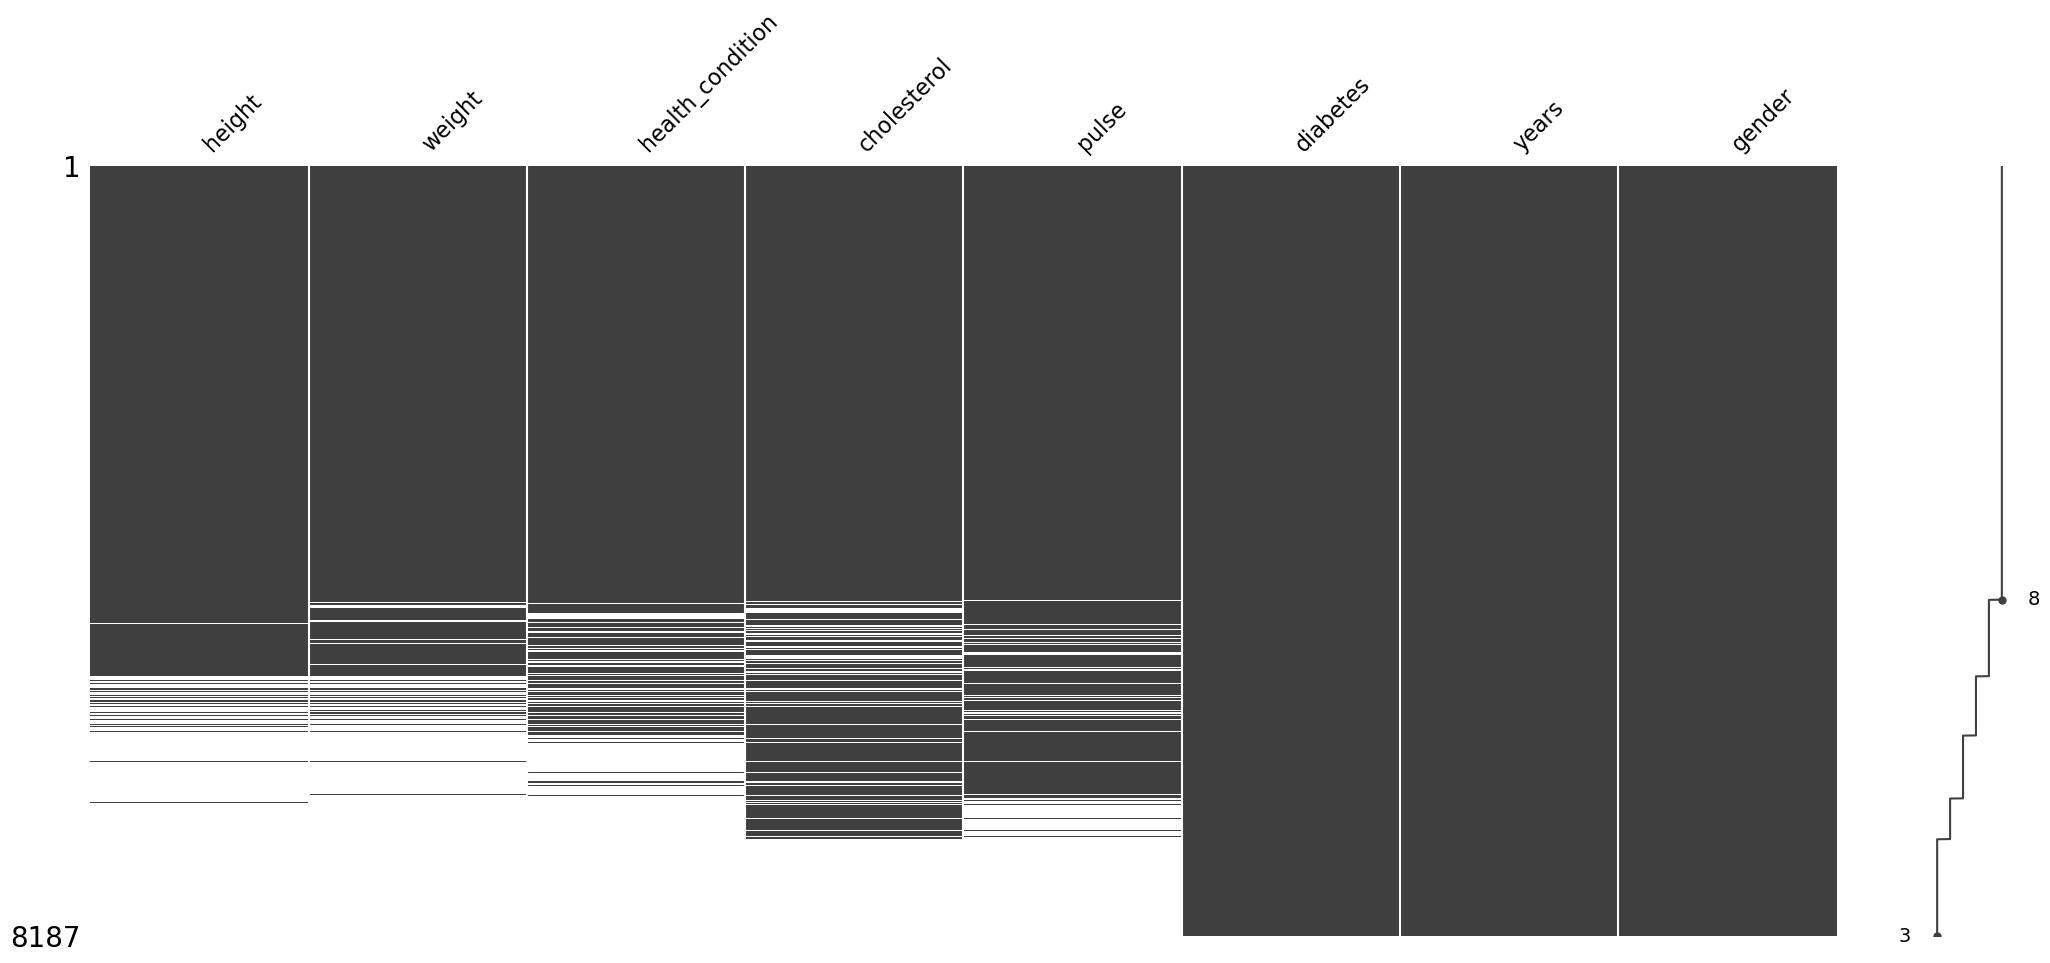

In [5]:
(
  nhanes_df
  .missing.sort_variables_by_missingness()
  .pipe(missingno.matrix, sort="descending")
)
plt.show()

Con el gráfico `matrix` podemos observar que de las 8 vairiables, 3 de ellas no tienen valores faltantes, mi entras que en las otras 5 si.  <br>
Una ventja de visualizar este gráfico con los datos organizados por valores faltantes, es que nos permite ver como hay espación en blanco (valores faltantes) que son continuos entre las variables, en otras palabras, se observa que cuando una variable tiene un valor faltante las otras también.

Para corroborar lo anterior, utilizamos el gráfico `upsetplot`, que nos muestra las relaciones entre las variables cuando hay presencia de valores faltantes:

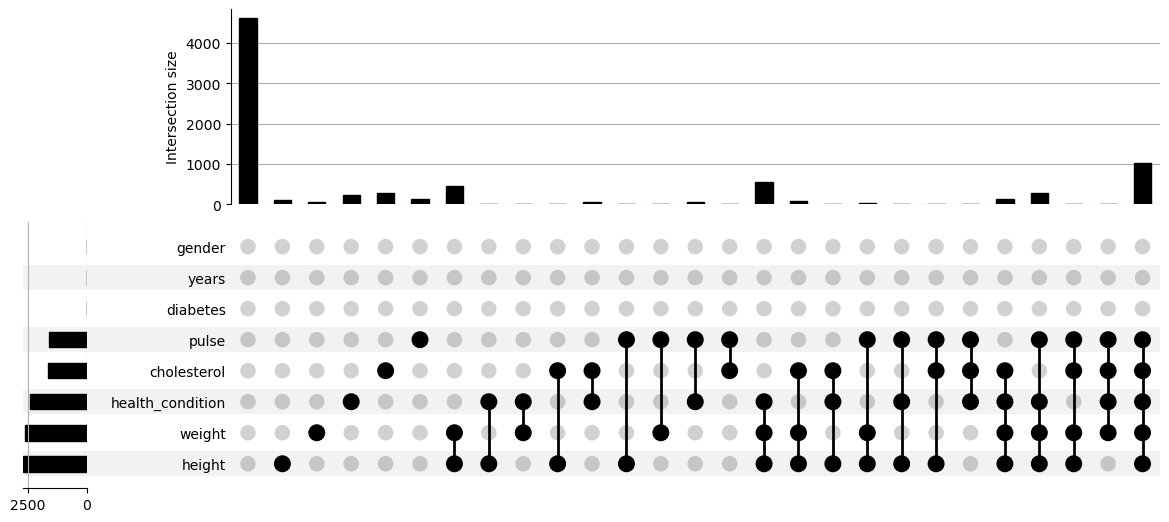

In [6]:
(
  nhanes_df
  .missing.sort_variables_by_missingness()
  .missing.missing_upsetplot()
)
plt.show()

Descripción del gráfico central (puntos):
- Filas: Variables
- Columnas: Combinaciones de aparición de valores faltantes por cada variable.
- Puntos en color gris: No hay presencia de valores faltantes en la variable
- Puntos en color negro: Hay presencia de valores faltantes en la variable
- Línea en color negro: Unión de valores faltantes en las variables, o bien es la representación de cuando hay valores faltantes en una variable en la otra(s) también los hay.


Descripción del gráfico superior y lateral izquierdo (barras):
- Cantidad de datos encontrados con esa combinación en el dataset.

Gracias al `upsetplot` corroboramos que existen al menos $1,000$ observaciones que no tienen las mediciones de `pulse`, `cholesterol`, `health condition`, `weight` y `height`. 

Para fines prácticos eliminamos aquellas observaciones donde tengamos valores faltantes simultáneos en las 5 variables.

📌 **NOTA:** Eliminar las observaciones con valores faltantes puede resultar contraproducente o bien no siempre es una buena idea, debemos de tener en cuenta el objetivo del análisis que se este desarrollando así como el contexto de los datos antes de proceder a eliminarlos.

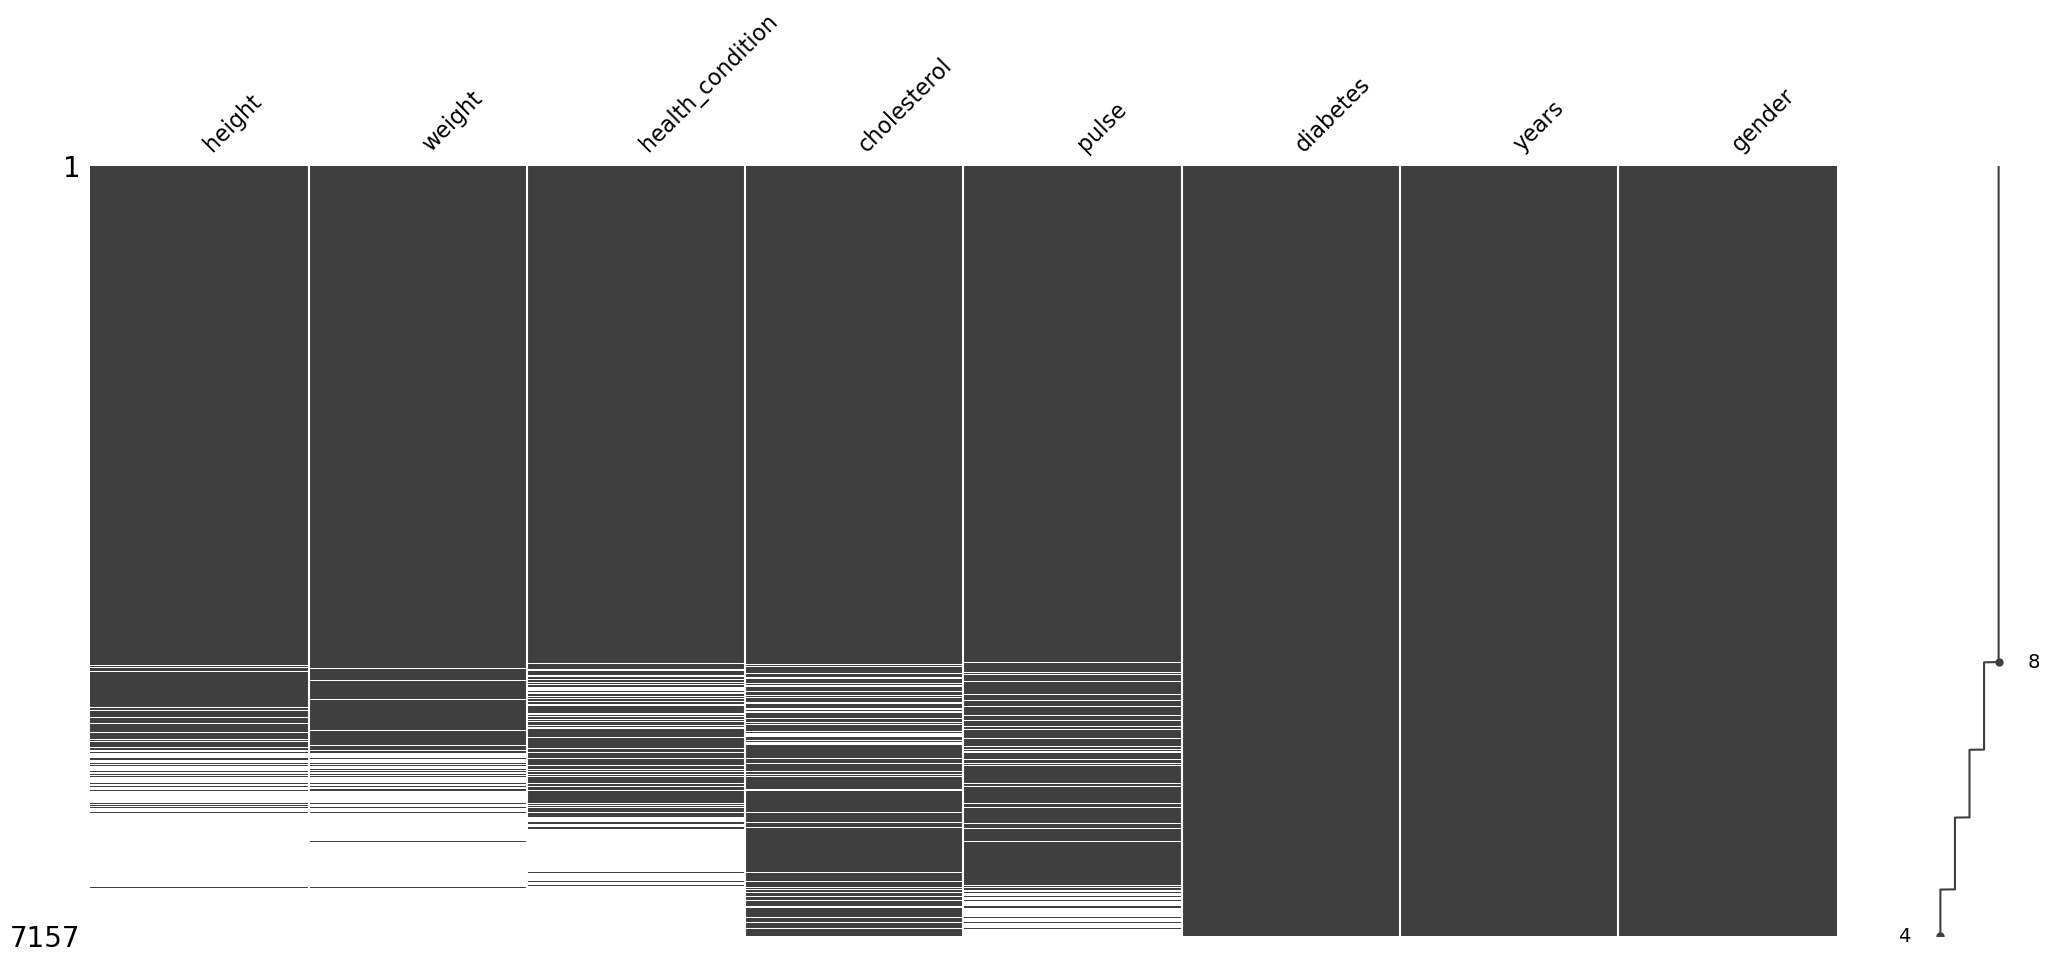

In [7]:
(
  nhanes_df
  .dropna(
    subset=["pulse", "cholesterol", "health_condition", "weight", "height"],
    how="all"
  )
  .missing.sort_variables_by_missingness()
  .pipe(missingno.matrix, sort="descending")
)

plt.show()

## Eliminar valores faltantes

In [8]:
nhanes_df = (
  nhanes_df
  .dropna(
    subset=["pulse", "cholesterol", "health_condition", "weight", "height"],
    how="all"
  )
  .missing.sort_variables_by_missingness()
)

nhanes_df.shape

(7157, 8)